# Тестовое задание на позицию Computer Vision Data Scientist

#FINE-TUNING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Задача

> **Необходимо построить классификатор деталей по фотографиям, который будет предсказывать один из двух классов: «маленькая» или «большая» деталь на изображении.**

> **Необходимо добиться максимальной точности предсказания классов.**

**В качестве решения необходимо приложить:**
- код обучения модели (может быть оформлен как .ipynb-ноутбук или файл с расширением .py)

- код использования модели (должен являться программным файлом расширения .py) со всеми необходимыми файлами для возможности проверки работы решения (например, весами обученной модели)

- файл readme с описанием запуска файла использования модели.

**Формат решения:** ссылка на репозиторий со всеми перечисленными файлами решения.

#### Время выполнения задания: 3 дня

**Данные**
- Имеются фотографии двух деталей – около 40 фотографий «большой» детали и около 20 фотографий «маленькой» детали.
- Две трети фотографий отнесены к обучающей выборке, треть – к тестовой.

Данные внутри обучающей и тестовых выборок разбиты на два класса: «маленькие» и «большие».

Ссылка на данные - https://drive.google.com/file/d/1RDAeRaX526vcZ4PcZnYqSFqsibmxMdmd/view


## Анализ решения 
1. Поставлена задача бинарной классификации изображений
1. Необходимо сделать исследование лучших моделей для ее решения 
1. Отобрать 3 кандидата на основании поиска и реализовать их 
1. Обучить модели 
1. Сделать сравнительный анализ результатов и отобрать лучшее решение 
1. Сделать развертывание лучшего решения 

**Особенности**

Нет ограничения на время обучения модели, главное добиться максимальной точности. 


> Результаты поиска показали, что для задачи бинарной классификации широкое распространение получили следующие архитектуры

- VGG 16 
- ResNet50 
- Inception v3
- Efficientnet

Учитывая тот факт, что в предоставленном наборе небольшое количество фотографий для обучения моделей с нуля, поэтому используем передаточное обучение и дообучим указанные архитектуры на наших данных, а затем выберем лучший результат.  



### IMPORT LIBRARIES

In [2]:
# GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random 

# PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
import itertools
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, \
    AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from tensorflow.keras.preprocessing import image

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical  # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall, Recall

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### PATH & LABEL PROCESS

In [3]:
# Main path
train_data_path = '/content/drive/MyDrive/Test_task_computer_vision/data/train/'

test_data_path = '/content/drive/MyDrive/Test_task_computer_vision/data/test/'

In [4]:
classes = {"big": "0", "small": "1"}

In [5]:
all_filenames_train = []
all_categories_train = []
for classElement in classes:
    filenames = os.listdir(train_data_path + classElement)
    all_filenames_train += [classElement + "/" + file for file in filenames]
    all_categories_train += [classes[classElement]] * len(filenames)

In [6]:
train_df = pd.DataFrame({'PICTURE': all_filenames_train,
                         'CATEGORY': all_categories_train})

In [7]:
# Checking results
train_df.tail()

,PICTURE,CATEGORY
38,small/IMG_7901.jpeg,1
39,small/IMG_7903.jpeg,1
40,small/IMG_7904.jpeg,1
41,small/IMG_7906.jpeg,1
42,small/IMG_7907.jpeg,1


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PICTURE   43 non-null     object
 1   CATEGORY  43 non-null     object
dtypes: object(2)
memory usage: 816.0+ bytes


In [9]:
all_filenames_test = []
all_categories_test = []
for classElement in classes:
    filenames = os.listdir(test_data_path + classElement)
    all_filenames_test += [classElement + "/" + file for file in filenames]
    all_categories_test += [classes[classElement]] * len(filenames)

In [10]:
test_df = pd.DataFrame({'PICTURE': all_filenames_test,
                        'CATEGORY': all_categories_test})

In [11]:
# Checking results
test_df.tail()

,PICTURE,CATEGORY
16,small/IMG_7896.jpeg,1
17,small/IMG_7899.jpeg,1
18,small/IMG_7902.jpeg,1
19,small/IMG_7905.jpeg,1
20,small/IMG_7915.jpeg,1


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PICTURE   21 non-null     object
 1   CATEGORY  21 non-null     object
dtypes: object(2)
memory usage: 464.0+ bytes


In [13]:
# Shuffling train data 
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df.head()

,PICTURE,CATEGORY
0,small/IMG_7900.jpeg,1
1,big/IMG_7849.jpeg,0
2,big/IMG_7852.jpeg,0
3,small/IMG_7898.jpeg,1
4,small/IMG_7895.jpeg,1


### VISUALIZATION: Distribution of classes

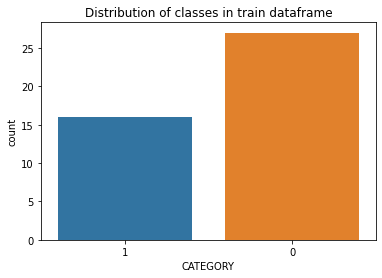

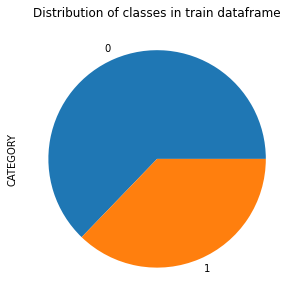

In [14]:
# General
sns.countplot(train_df["CATEGORY"])
plt.title('Distribution of classes in train dataframe')
plt.show()

plt.title('Distribution of classes in train dataframe')
train_df['CATEGORY'].value_counts().plot.pie(figsize=(5, 5))
plt.show()

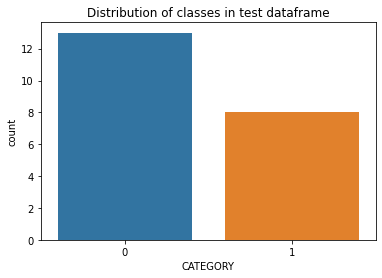

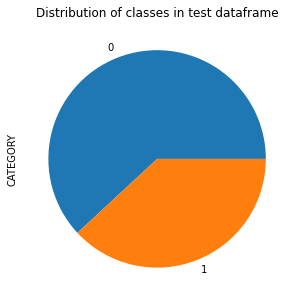

In [15]:
sns.countplot(test_df["CATEGORY"])
plt.title('Distribution of classes in test dataframe')
plt.show()

plt.title('Distribution of classes in test dataframe')
test_df['CATEGORY'].value_counts().plot.pie(figsize=(5, 5))
plt.show()

# DATA PREPARATION

In [16]:
print(f'Train class value counts: \n{train_df["CATEGORY"].value_counts()}')
print(f'Test class value counts: \n{test_df["CATEGORY"].value_counts()}')

Train class value counts: 
0    27
1    16
Name: CATEGORY, dtype: int64
Test class value counts: 
0    13
1     8
Name: CATEGORY, dtype: int64


#### Image generator

In [17]:
train_generator = ImageDataGenerator(rescale=1. / 256,
                                     shear_range=0.3,
                                     zoom_range=0.2,
                                     rotation_range=30,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')

In [18]:
validation_generator = ImageDataGenerator(rescale=1. / 256)

In [19]:
test_generator = ImageDataGenerator(rescale=1. / 256)

#### Applying generator and transformation to tensor

In [20]:
print("Preparing the training data:")
train_images = train_generator.flow_from_dataframe(train_df,
                                                   directory=train_data_path,
                                                   x_col='PICTURE',
                                                   y_col='CATEGORY',
                                                   target_size=(256, 256),
                                                   class_mode='binary',
                                                   batch_size=16)


Preparing the training data:
Found 43 validated image filenames belonging to 2 classes.


In [21]:
print("Preparing the validation data:")
valid_images = validation_generator.flow_from_dataframe(train_df,
                                                        directory=train_data_path,
                                                        x_col='PICTURE',
                                                        y_col='CATEGORY',
                                                        target_size=(256, 256),
                                                        class_mode='binary',
                                                        batch_size=16)

Preparing the validation data:
Found 43 validated image filenames belonging to 2 classes.


In [22]:
print("Preparing the test data:")
test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 directory=test_data_path,
                                                 x_col='PICTURE',
                                                 y_col='CATEGORY',
                                                 target_size=(256, 256),
                                                 class_mode='binary',
                                                 batch_size=16)

Preparing the test data:
Found 21 validated image filenames belonging to 2 classes.


In [23]:
# Checking
print("Checking the training data:")
for data_batch, label_batch in train_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

Checking the training data:
DATA SHAPE:  (16, 256, 256, 3)
LABEL SHAPE:  (16,)


In [24]:
print("Checking the test data:")
for data_batch, label_batch in test_images:
    print("DATA SHAPE: ", data_batch.shape)
    print("LABEL SHAPE: ", label_batch.shape)
    break

Checking the test data:
DATA SHAPE:  (16, 256, 256, 3)
LABEL SHAPE:  (16,)


### Evaluation and visualization of model parameters

In [25]:
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['accuracy'], label="Training accuracy")
    axR.plot(history.history['val_accuracy'], label="Validation accuracy")
    axR.set_title('Training and Validation accuracy')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('Accuracy')
    axR.legend(loc='upper right')

    plt.show()


def model_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)
    plt.show()


# FINE-TUNING MODEL VGG-16

In [26]:
# Base model
VGG16 = VGG16(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
VGG16.trainable = True

In [27]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(VGG16.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [28]:
# Freeze all layers except for the
for layer in VGG16.layers[:15]:
  layer.trainable = False

In [29]:
# Check which layers are tuneable (trainable)
for i, layer in enumerate(VGG16.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


#### Fine-tuning model

In [30]:
tf.random.set_seed(1)

last_layer = VGG16.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
vgg_model = Model(inputs=VGG16.input, outputs=x)

In [31]:
# Compile the model
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])


In [32]:
 vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [33]:
vgg_history = vgg_model.fit(train_images,
                            validation_data=valid_images,
                            epochs=5)

Epoch 1/5
3/3 [==============================] - 31s 11s/step - loss: 0.9600 - accuracy: 0.6744 - val_loss: 0.0421 - val_accuracy: 1.0000
Epoch 2/5
3/3 [==============================] - 22s 9s/step - loss: 0.2760 - accuracy: 0.9070 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 3/5
3/3 [==============================] - 22s 9s/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 1.6791e-04 - val_accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 22s 9s/step - loss: 0.0664 - accuracy: 0.9535 - val_loss: 3.2548e-10 - val_accuracy: 1.0000
Epoch 5/5
3/3 [==============================] - 22s 9s/step - loss: 6.4234e-10 - accuracy: 1.0000 - val_loss: 1.7236e-22 - val_accuracy: 1.0000


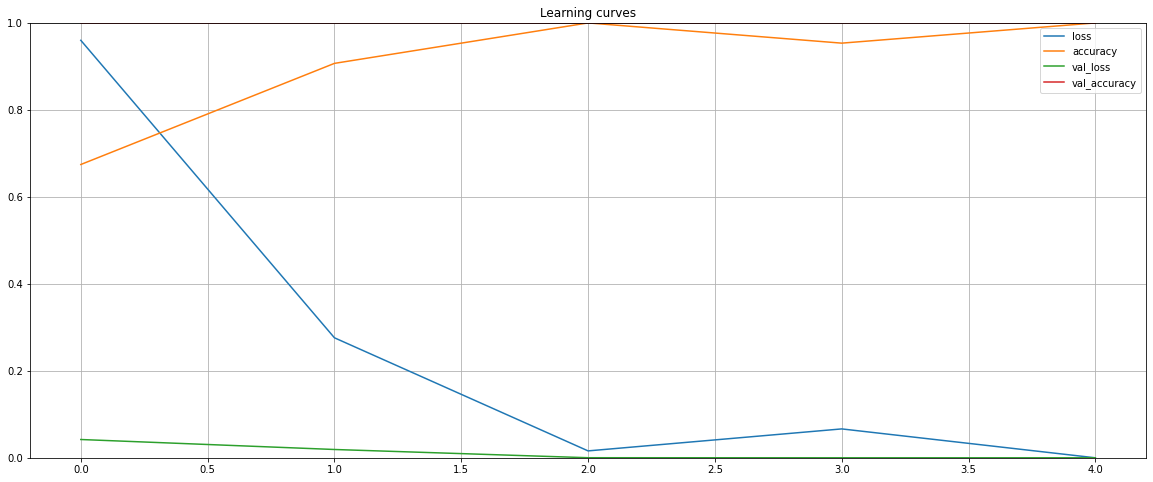

In [34]:
# Learning curves
learning_curves(vgg_history)

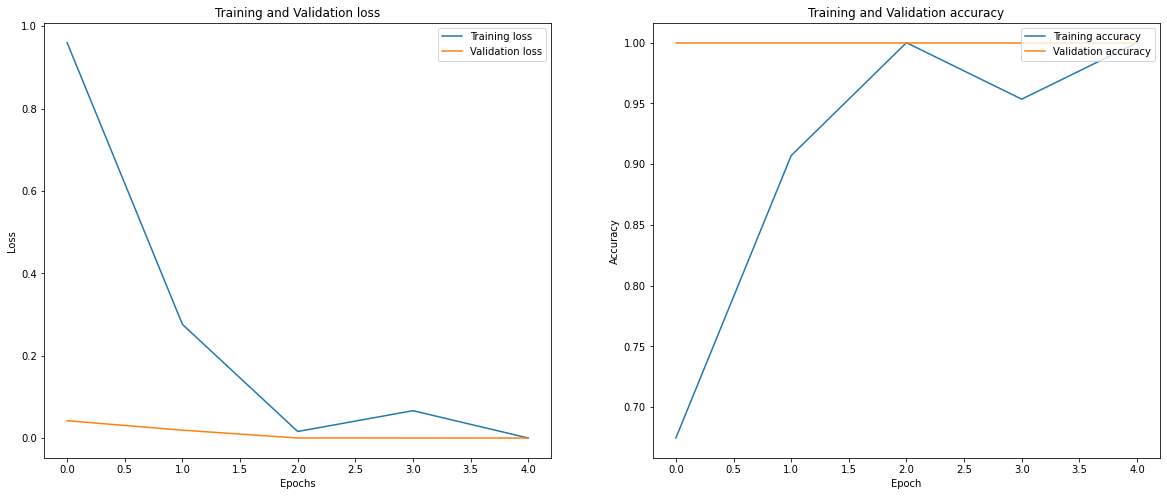

In [35]:
# Evaluation model
evaluation_model(vgg_history)

In [36]:
# Evaluate the model on the test set
evaluate_vgg = vgg_model.evaluate(test_images, verbose=2)

2/2 - 6s - loss: 1.7828e-24 - accuracy: 1.0000 - 6s/epoch - 3s/step


In [37]:
# Predicting the test set results
threshold = 0.5

y_pred = vgg_model.predict(test_images)
y_pred_class = np.where(y_pred > threshold, 1,0)

prediction_class = LabelEncoder().fit_transform(test_df["CATEGORY"])


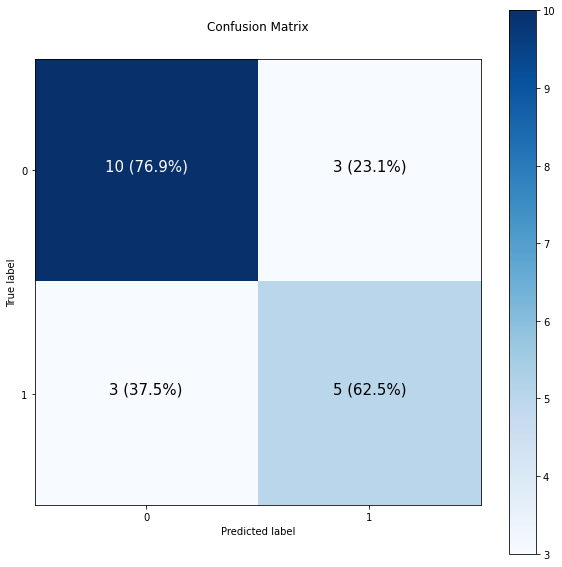

In [38]:
# Confusion matrix
model_confusion_matrix(prediction_class, y_pred_class)

In [39]:
# Classification report
report = classification_report(prediction_class, y_pred_class, target_names=['big','small'])
print(report)

              precision    recall  f1-score   support

         big       0.77      0.77      0.77        13
       small       0.62      0.62      0.62         8

    accuracy                           0.71        21
   macro avg       0.70      0.70      0.70        21
weighted avg       0.71      0.71      0.71        21



# FINE-TUNING MODEL ResNet50

In [40]:
# Base model
ResNet = ResNet50(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
ResNet.trainable = True

In [41]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(ResNet.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [42]:
# Freeze all conv_base 
for layer in ResNet.layers[:-10]:
  layer.trainable = False

In [43]:
# Check which layers are tuneable (trainable)
for i, layer in enumerate(ResNet.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

#### Fine-tuning model

In [44]:
tf.random.set_seed(2)


last_layer = ResNet.get_layer('conv5_block3_out')
last_output = last_layer.output
    
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=ResNet.input, outputs=x)

In [45]:
# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])

In [46]:
 resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [47]:
resnet_history = resnet_model.fit(train_images,
                            validation_data=valid_images,
                            epochs=5)

Epoch 1/5
3/3 [==============================] - 32s 12s/step - loss: 2.1350 - accuracy: 0.4419 - val_loss: 0.8441 - val_accuracy: 0.3721
Epoch 2/5
3/3 [==============================] - 22s 9s/step - loss: 1.6344 - accuracy: 0.5581 - val_loss: 0.7862 - val_accuracy: 0.3721
Epoch 3/5
3/3 [==============================] - 22s 10s/step - loss: 2.9896 - accuracy: 0.4651 - val_loss: 0.7247 - val_accuracy: 0.4419
Epoch 4/5
3/3 [==============================] - 22s 10s/step - loss: 2.0270 - accuracy: 0.5581 - val_loss: 0.6571 - val_accuracy: 0.4419
Epoch 5/5
3/3 [==============================] - 22s 9s/step - loss: 1.8676 - accuracy: 0.4186 - val_loss: 0.6361 - val_accuracy: 0.6279


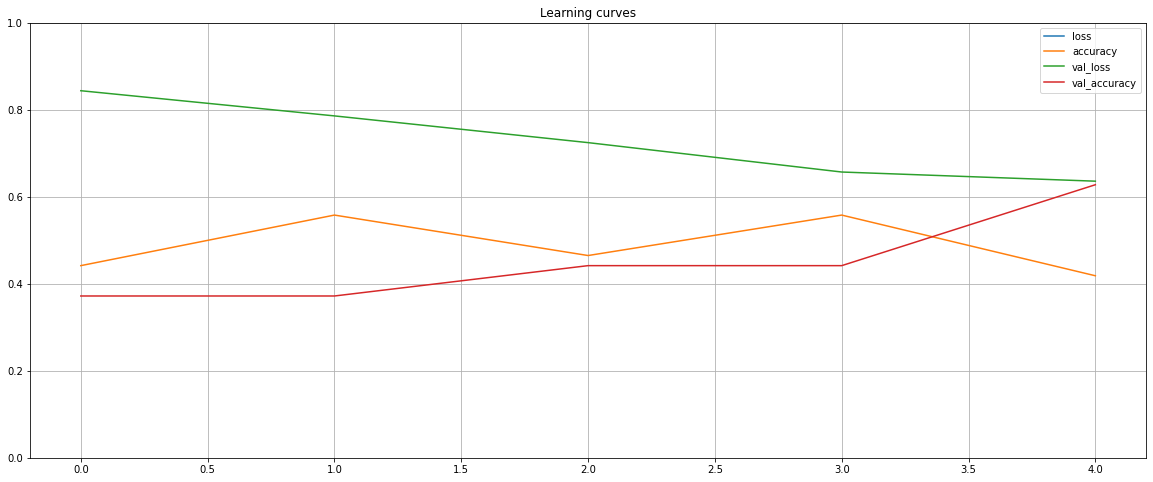

In [48]:
# Learning curves
learning_curves(resnet_history)

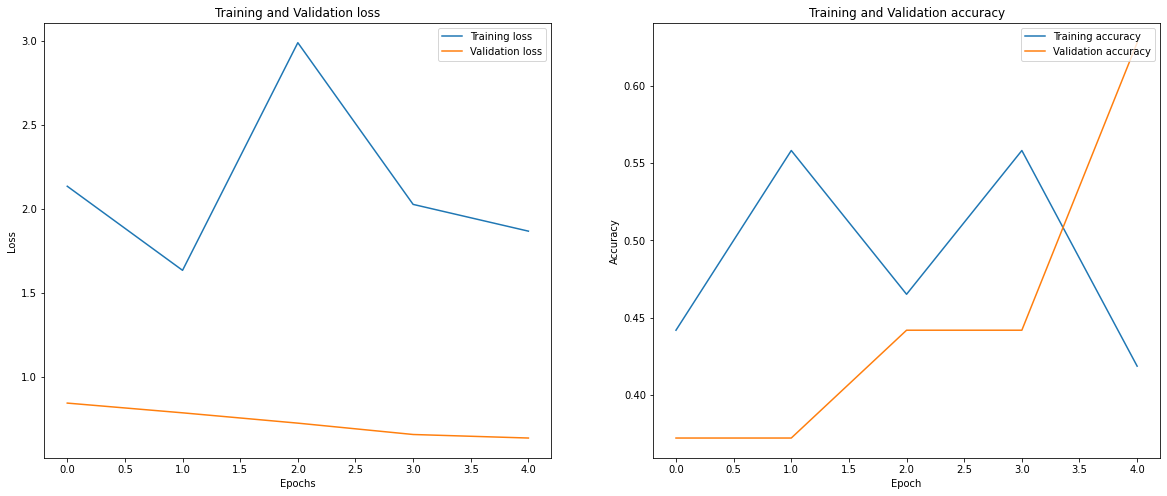

In [49]:
# Evaluation model
evaluation_model(resnet_history)

In [50]:
# Evaluate the model on the test set
evaluate_resnet = resnet_model.evaluate(test_images, verbose=2)

2/2 - 5s - loss: 0.6388 - accuracy: 0.6190 - 5s/epoch - 3s/step


In [51]:
# Predicting the test set results
threshold = 0.5

y_pred = resnet_model.predict(test_images)
y_pred_class = np.where(y_pred > threshold, 1,0)

prediction_class = LabelEncoder().fit_transform(test_df["CATEGORY"])

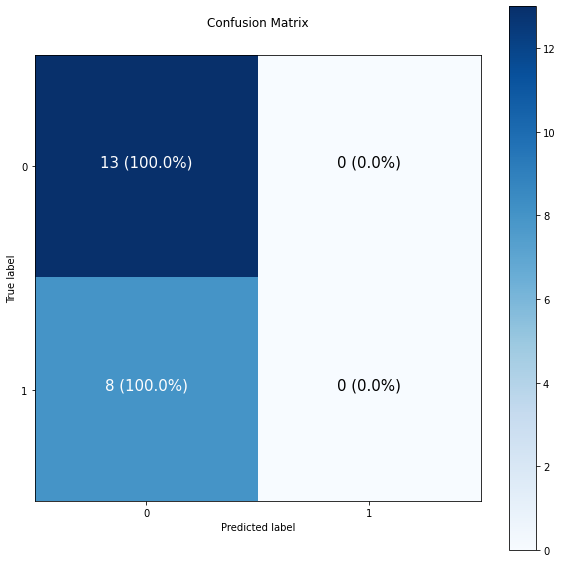

In [52]:
# Confusion matrix
model_confusion_matrix(prediction_class, y_pred_class)

In [53]:
# Classification report
report = classification_report(prediction_class, y_pred_class, target_names=['big','small'])
print(report)

              precision    recall  f1-score   support

         big       0.62      1.00      0.76        13
       small       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# FINE-TUNING MODEL Inception v3

In [54]:
# Base model
Inception= InceptionV3(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
Inception.trainable = True

In [55]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(Inception.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

In [56]:
# Freeze all conv_base 
for layer in Inception.layers[:-17]:
  layer.trainable = False

In [57]:
# Check which layers are tuneable (trainable)
for i, layer in enumerate(Inception.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

#### Fine-tuning model

In [58]:
tf.random.set_seed(3)

x = Inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(1, activation='sigmoid')(x) 
inception_model = Model(inputs=Inception.input, outputs=x)

In [59]:
# Compile the model
inception_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])


In [60]:
 inception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [61]:
inception_history = inception_model.fit(train_images,
                            validation_data=valid_images,
                            epochs=5)

Epoch 1/5
3/3 [==============================] - 34s 12s/step - loss: 0.6915 - accuracy: 0.6512 - val_loss: 0.4551 - val_accuracy: 0.6977
Epoch 2/5
3/3 [==============================] - 22s 9s/step - loss: 0.4733 - accuracy: 0.8837 - val_loss: 0.3325 - val_accuracy: 0.9535
Epoch 3/5
3/3 [==============================] - 22s 10s/step - loss: 0.4360 - accuracy: 0.7907 - val_loss: 0.2227 - val_accuracy: 1.0000
Epoch 4/5
3/3 [==============================] - 22s 10s/step - loss: 0.2583 - accuracy: 0.9302 - val_loss: 0.1411 - val_accuracy: 1.0000
Epoch 5/5
3/3 [==============================] - 22s 9s/step - loss: 0.2272 - accuracy: 0.9767 - val_loss: 0.0900 - val_accuracy: 1.0000


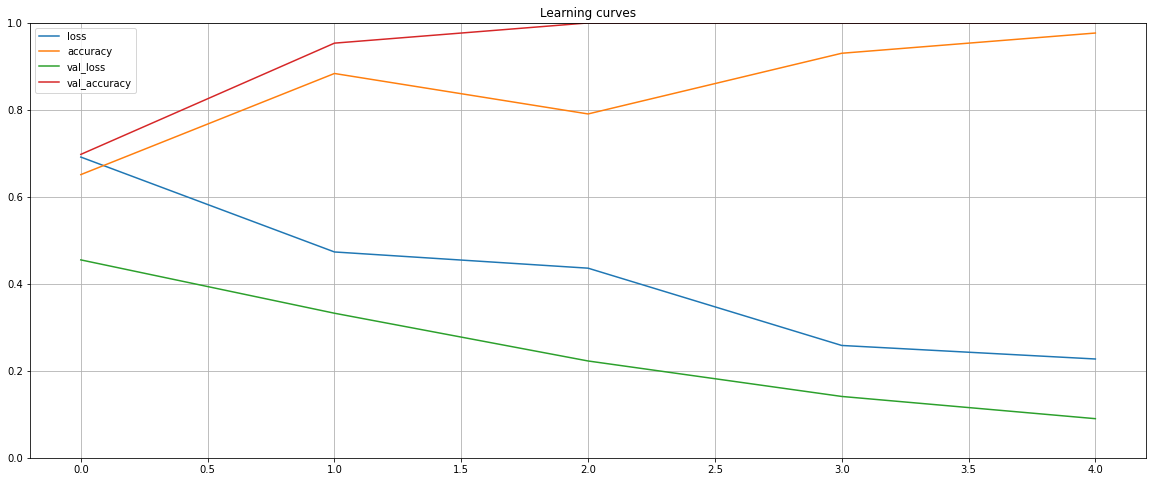

In [62]:
# Learning curves
learning_curves(inception_history)

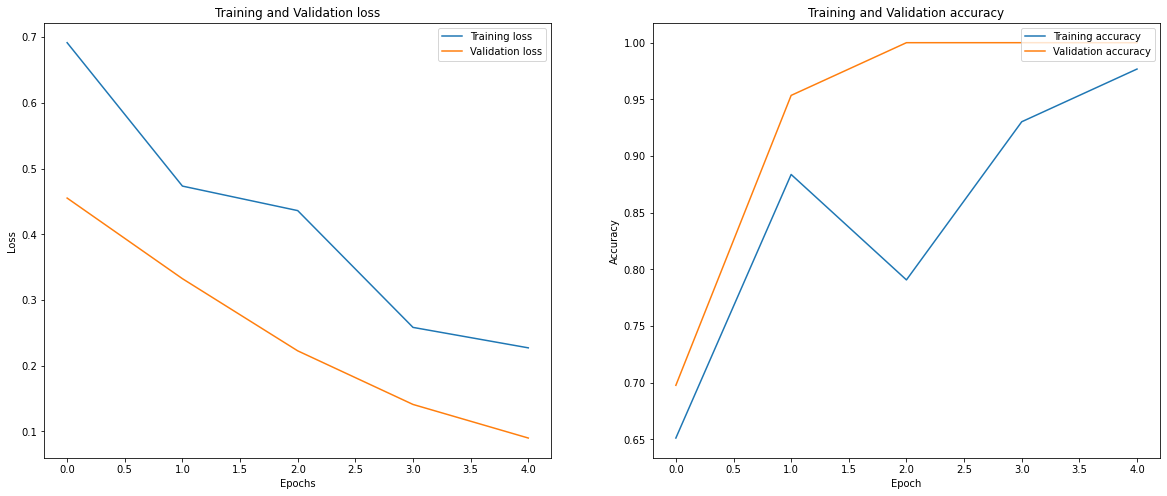

In [63]:
# Evaluation model
evaluation_model(inception_history)

In [64]:
# Evaluate the model on the test set
evaluate_inception = inception_model.evaluate(test_images, verbose=2)

2/2 - 6s - loss: 0.1037 - accuracy: 1.0000 - 6s/epoch - 3s/step


In [65]:
# Predicting the test set results
threshold = 0.5

y_pred = inception_model.predict(test_images)
y_pred_class = np.where(y_pred > threshold, 1,0)

prediction_class = LabelEncoder().fit_transform(test_df["CATEGORY"])

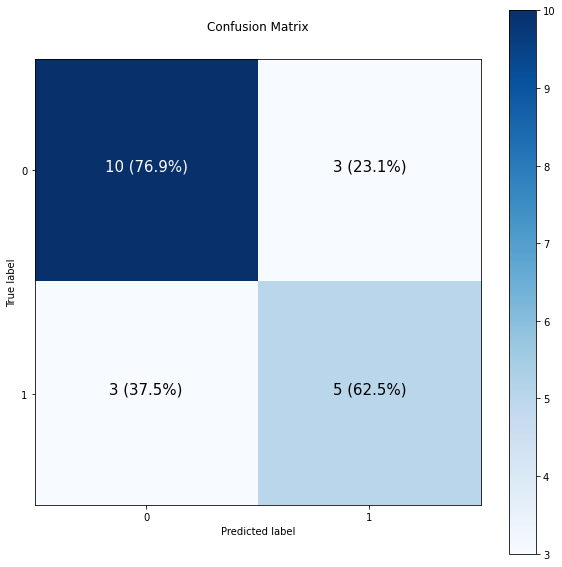

In [66]:
# Confusion matrix
model_confusion_matrix(prediction_class, y_pred_class)

In [67]:
# Classification report
report = classification_report(prediction_class, y_pred_class, target_names=['big','small'])
print(report)

              precision    recall  f1-score   support

         big       0.77      0.77      0.77        13
       small       0.62      0.62      0.62         8

    accuracy                           0.71        21
   macro avg       0.70      0.70      0.70        21
weighted avg       0.71      0.71      0.71        21



# Save a model

Сохраним модель несколькими способами для дальнейшего использования в продакшине и подтверждения результатов.  


In [68]:
# Save a model
inception_model.save("inception_part_classifier")

INFO:tensorflow:Assets written to: inception_part_classifier/assets


In [69]:
# Save a model weights
inception_model.save_weights("weights/inception_part_classifier")

In [70]:
# Save model to HDF5 format
inception_model.save("inception_part_classifier.h5")

In [71]:
# Save  model to pickle format
joblib.dump(inception_model, "inception_part_classifier.pkl")

INFO:tensorflow:Assets written to: ram://0dc3b28e-532a-4104-a82e-183bd58936e4/assets


['inception_part_classifier.pkl']

# FINE-TUNING MODEL Efficientnet

In [72]:
# Base model
Efficientnet= EfficientNetB0(input_shape=(256, 256, 3), include_top=False)
Efficientnet.trainable = True

In [73]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(Efficientnet.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 True
1 rescaling True
2 normalization True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 block

In [74]:
# Freeze all conv_base 
for layer in Efficientnet.layers[:-17]:
  layer.trainable = False

In [75]:
# Check which layers are tuneable (trainable)
for i, layer in enumerate(Inception.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

#### Fine-tuning model

In [76]:
tf.random.set_seed(42)

x = Efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x) 
x = Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dense(1, activation='sigmoid')(x) 
efficientnet_model = Model(inputs=Efficientnet.input, outputs=x)

In [77]:
# Compile the model
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=["accuracy"])


In [78]:
 efficientnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']    

In [79]:
efficientnet_history = efficientnet_model.fit(train_images,
                            validation_data=valid_images,
                            epochs=5)

Epoch 1/5
3/3 [==============================] - 36s 12s/step - loss: 1.4243 - accuracy: 0.5116 - val_loss: 1.3591 - val_accuracy: 0.6279
Epoch 2/5
3/3 [==============================] - 22s 9s/step - loss: 1.4087 - accuracy: 0.5581 - val_loss: 1.3487 - val_accuracy: 0.6279
Epoch 3/5
3/3 [==============================] - 22s 10s/step - loss: 1.4115 - accuracy: 0.5814 - val_loss: 1.3450 - val_accuracy: 0.6279
Epoch 4/5
3/3 [==============================] - 22s 10s/step - loss: 1.3799 - accuracy: 0.4651 - val_loss: 1.3473 - val_accuracy: 0.3721
Epoch 5/5
3/3 [==============================] - 22s 10s/step - loss: 1.4177 - accuracy: 0.3953 - val_loss: 1.3224 - val_accuracy: 0.6279


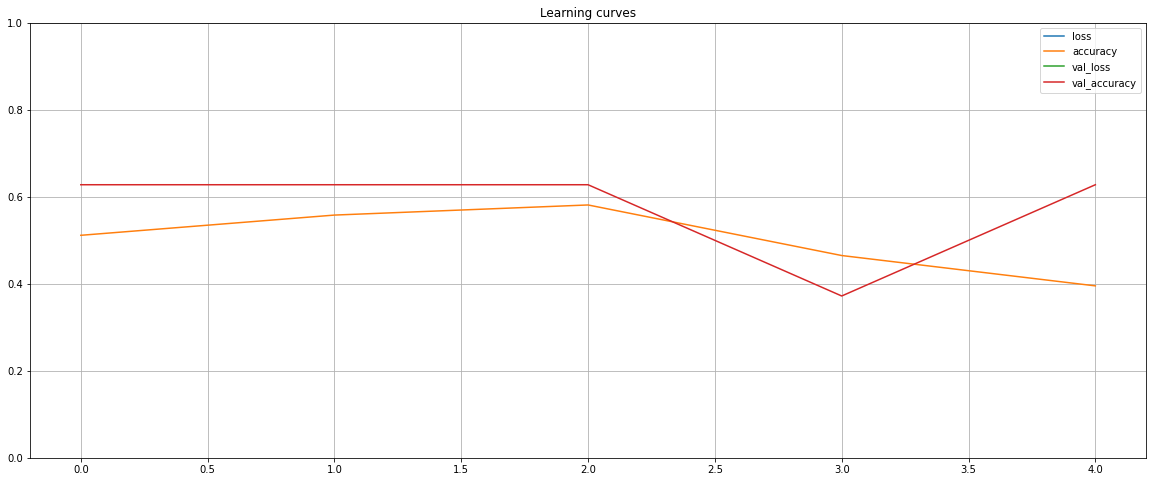

In [80]:
# Learning curves
learning_curves(efficientnet_history)

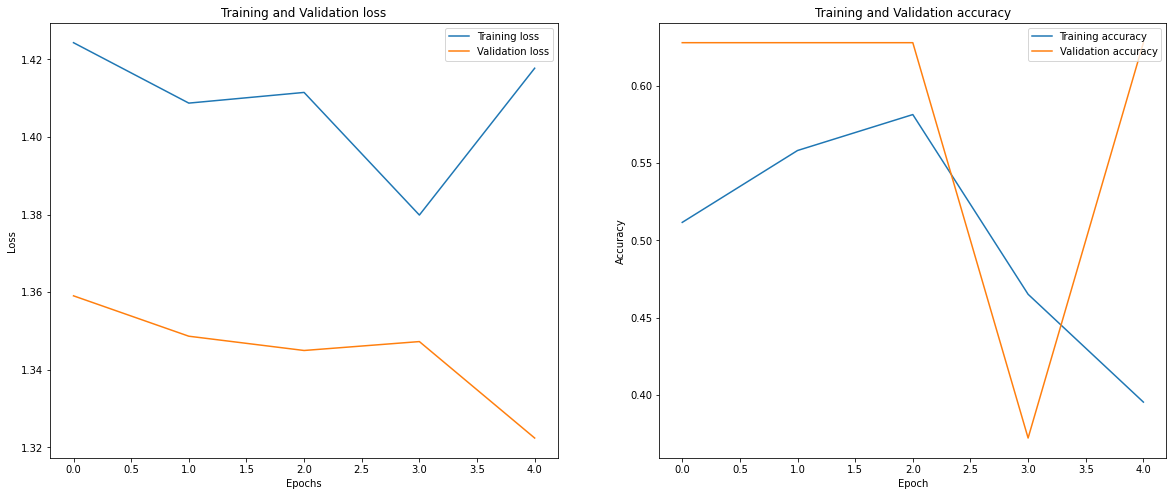

In [81]:
# Evaluation model
evaluation_model(efficientnet_history)

In [82]:
# Evaluate the model on the test set
evaluat_efficientnet = efficientnet_model.evaluate(test_images, verbose=2)

2/2 - 5s - loss: 1.3228 - accuracy: 0.6190 - 5s/epoch - 3s/step


In [83]:
# Predicting the test set results
threshold = 0.5

y_pred = efficientnet_model.predict(test_images)
y_pred_class = np.where(y_pred > threshold, 1,0)

prediction_class = LabelEncoder().fit_transform(test_df["CATEGORY"])

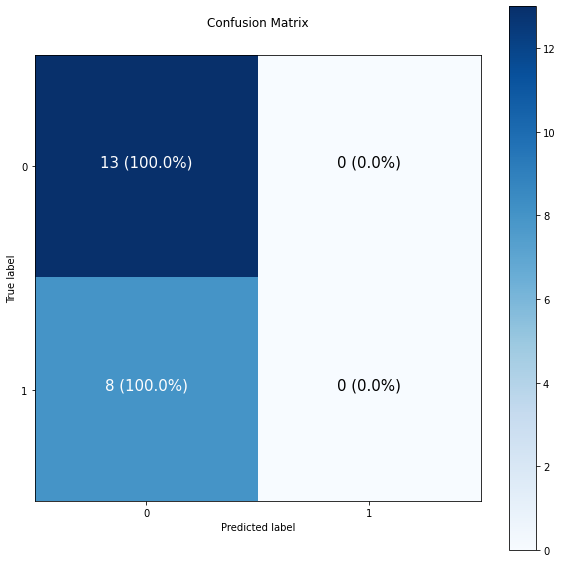

In [84]:
# Confusion matrix
model_confusion_matrix(prediction_class, y_pred_class)

In [85]:
# Classification report
report = classification_report(prediction_class, y_pred_class, target_names=['big','small'])
print(report)

              precision    recall  f1-score   support

         big       0.62      1.00      0.76        13
       small       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
